## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №31

#### Обучить сеть GAN для генерации изображений лиц

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow  as tf
from tensorflow import keras
from keras import layers

RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Cuda version: 2.10.1
Num GPUs Available:  1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

Загрузить набор изображение из файла

In [3]:
DATA_PATH = "images"
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

BATCH_SIZE = 64

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory=DATA_PATH, label_mode=None, image_size=(IMAGE_HEIGHT,IMAGE_WIDTH), batch_size=BATCH_SIZE)

Found 63565 files belonging to 1 classes.


Отобразить произвольный набор изображений

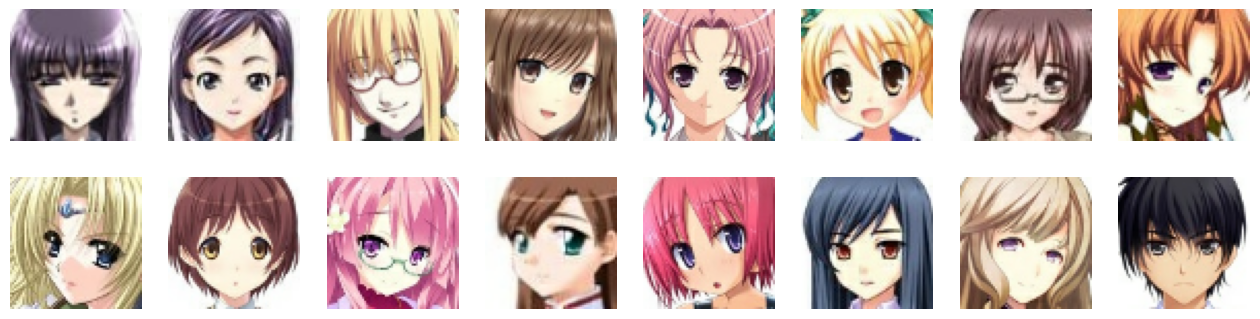

In [4]:
plt.figure(figsize=(16, 4))
for images in image_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(2, 8, i + 1)
        ax.imshow(images[i].numpy().astype("uint8"))
        ax.axis("off")

Определение сети дескриминатора, обучающейся на наборе загруженных изображений

In [5]:
discriminator = keras.models.Sequential([
    layers.Conv2D(128, (3,3), padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),

    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.BatchNormalization(),

    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(128),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1, activation='sigmoid')
])      
        
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

Определение сети генератора, генерирующей изображения из входного шума

In [6]:
LATENT_DIMENSION = 100 # Количество точек, используемых как входной массив для генератора изображений
EPSILON = 0.00001 # Небольшое значение, добавляемое к дисперсии для избежания деления на 0 в слоях BatchNormalization.
        
generator = keras.models.Sequential([
    layers.Dense(4*4*256, input_dim = LATENT_DIMENSION),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((4, 4, 256)),
            
    layers.Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                           kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)),
    layers.BatchNormalization(momentum=0.9, epsilon=EPSILON),
    layers.LeakyReLU(alpha=0.2),
            
    layers.Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                           kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)),
    layers.BatchNormalization(momentum=0.9, epsilon=EPSILON),
    layers.LeakyReLU(alpha=0.2),
            
    layers.Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                           kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)),
    layers.BatchNormalization(momentum=0.9, epsilon=EPSILON),
    layers.LeakyReLU(alpha=0.2),
            
    layers.Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                           kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)),
    layers.BatchNormalization(momentum=0.9, epsilon=EPSILON),
    layers.LeakyReLU(alpha=0.2),
           
    layers.Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                           kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)),

    # Стандартная функция активации для генератора GAN
    layers.Activation("tanh")
])
        
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1048832   
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 256)        

Определение класcа нейронной сети GAN

In [7]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim=LATENT_DIMENSION):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, loaded_images):
        # Определяем размер батча для обучения
        batch_size = tf.shape(loaded_images)[0]

        # Формируем набор случайных "заготовок" для генерации изображений
        image_seeds = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Генерируем изображения из случайного шума
        generated_images = self.generator(image_seeds)

        # Собираем вместе сгенерированные и загруженные изображения
        combined_images = tf.concat([generated_images, loaded_images], axis=0)
        # Собираем метки классов: 1 для сгенерированных изображений, 0 для загруженных изображений
        combined_labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Добавляем шум к сформированным меткам (это важно!!!)
        combined_labels += 0.05 * tf.random.uniform(tf.shape(combined_labels))
        
        # Обучаем дискриминатор
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(combined_labels, predictions)
        gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        # Заново формируем набор "заготовок" для генерации изображений
        image_seeds = tf.random.normal(shape=(batch_size, self.latent_dim))
        # при этом формируем метки как для загруженных изоюражений (0)
        generated_labels = tf.zeros((batch_size, 1))

        # Обучаем генератор (При этом мы Не обновляем веса дискриминатора!!!)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(image_seeds))
            g_loss = self.loss_fn(generated_labels, predictions)
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))

        # Обновляем метрики моделей
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        # Формируем и возвращаем информацию об изменении метрик
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Нормализация входных данных

In [8]:
image_dataset = image_dataset.map(lambda x: x / 255.0)

Создание и обучение модели GAN

In [9]:
EPOCHS = 10
LEARNING_RATE = 0.0001

# Оптимизатор для дискриминатора и генератора
optimizer = keras.optimizers.Nadam(LEARNING_RATE, 0.5)
# Функция потерь
loss_fn = keras.losses.BinaryCrossentropy()

# Создание и компиляция модели GAN
model = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIMENSION)
model.compile(d_optimizer=optimizer, g_optimizer=optimizer, loss_fn=loss_fn)

# Обучение модели
history = model.fit(image_dataset, epochs=EPOCHS)

Epoch 1/10
994/994 [==============================] - 267s 261ms/step - d_loss: 0.4241 - g_loss: 2.0456
Epoch 2/10
994/994 [==============================] - 260s 261ms/step - d_loss: 0.3490 - g_loss: 2.6081
Epoch 3/10
994/994 [==============================] - 259s 261ms/step - d_loss: 0.2914 - g_loss: 2.9965
Epoch 4/10
994/994 [==============================] - 260s 261ms/step - d_loss: 0.2358 - g_loss: 3.3670
Epoch 5/10
994/994 [==============================] - 260s 261ms/step - d_loss: 0.2080 - g_loss: 3.7026
Epoch 6/10
994/994 [==============================] - 259s 261ms/step - d_loss: 0.1748 - g_loss: 4.3087
Epoch 7/10
994/994 [==============================] - 259s 261ms/step - d_loss: 0.1735 - g_loss: 4.4601
Epoch 8/10
994/994 [==============================] - 259s 261ms/step - d_loss: 0.1880 - g_loss: 4.4809
Epoch 9/10
994/994 [==============================] - 259s 261ms/step - d_loss: 0.1918 - g_loss: 4.4069
Epoch 10/10
994/994 [==============================] - 259s 261m

Визуализация метрик обучения

Text(0.5, 1.0, 'Кривые функций потерь')

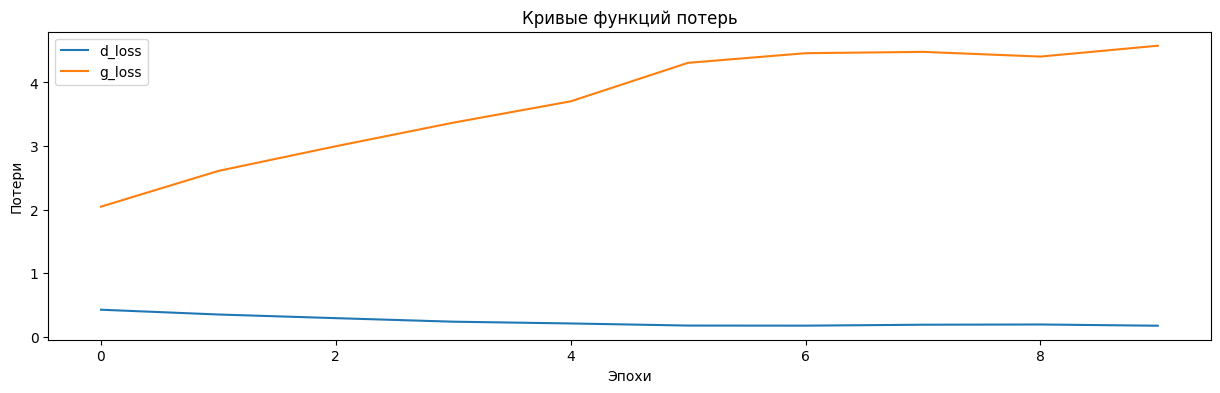

In [10]:
pd.DataFrame(history.history).plot(figsize=(15,4))
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.title('Кривые функций потерь')

Генерация изображений из случайного шума

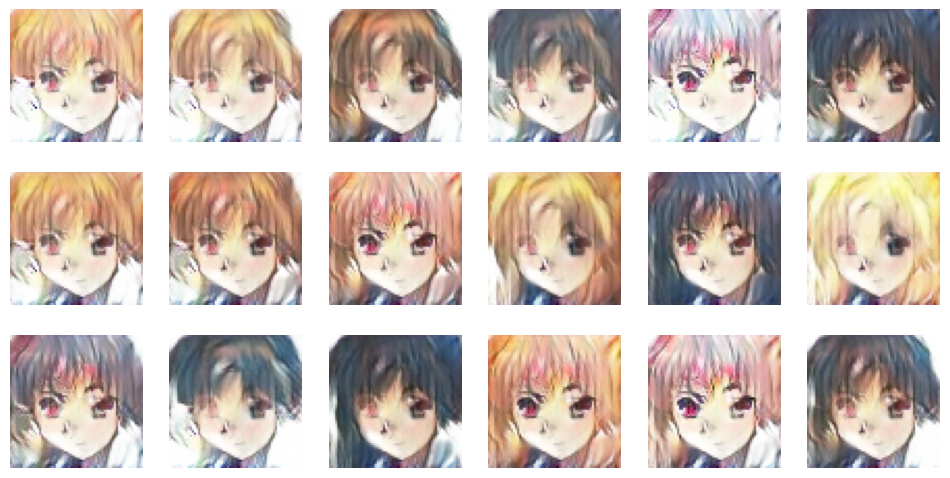

In [11]:
# Количество генерируемых изображений
IMAGE_NUMBER=18

images_list = []
image_seeds = tf.random.normal([IMAGE_NUMBER, LATENT_DIMENSION])
generated_images = generator(image_seeds)
#generated_images *= 255 
generated_images = generated_images.numpy()
for i in range(IMAGE_NUMBER):
    image = tf.keras.preprocessing.image.array_to_img(generated_images[i])
    images_list.append(image)

plt.figure(figsize=(12, 6))
for i in range(len(images_list)):
    ax = plt.subplot(3, 6, i + 1)
    ax.imshow(images_list[i])
    ax.axis("off")